# Genetic Algorithm for Sequential Ordering Problem


In [ ]:
import random
import time
import numpy as np
from collections import defaultdict
import os
from pathlib import Path
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt

## The Sequential Ordering Problem


In [ ]:
class SOP:
    def __init__(self, file_path):

        self.file_path = file_path
        self.file_name = Path(file_path).name
        self.nodes, self.costs, self.precedence = self.parse_file(file_path)
        self.size = len(self.nodes)
        
        # Create precedence graph for faster validation
        self.before = defaultdict(set)
        self.after = defaultdict(set)
        self.build_precedence_graph()

    def parse_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Extract dimension
        dimension = next(int(line.strip().split(':')[1]) 
                         for line in lines if line.startswith('DIMENSION'))
        
        # Find the start of matrix data
        matrix_start = next(i for i, line in enumerate(lines) 
                           if line.startswith('EDGE_WEIGHT_SECTION')) + 1
        
        # Skip the dimension line if present
        if lines[matrix_start].strip().isdigit():
            matrix_start += 1
        
        # Parse the matrix
        matrix_data = []
        for i in range(matrix_start, matrix_start + dimension):
            row = list(map(int, lines[i].strip().split()))
            matrix_data.append(row)
        
        # Convert to numpy array for faster operations
        costs_matrix = np.array(matrix_data)
        
        # Extract nodes and costs
        nodes = list(range(1, dimension + 1))
        costs = {}
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] != -1:
                    costs[(i+1, j+1)] = costs_matrix[i, j]
        
        # Extract precedence constraints (wherever there's a -1)
        precedence = []
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] == -1 and i != j:
                    precedence.append((j+1, i+1))
        
        return nodes, costs, precedence

    def build_precedence_graph(self):
        for u, v in self.precedence:
            self.before[v].add(u)
            self.after[u].add(v)
        
        # Transitive closure - if a→b and b→c then a→c
        changed = True
        while changed:
            changed = False
            for node in self.nodes:
                old_before = self.before[node].copy()
                for b in old_before:
                    self.before[node].update(self.before[b])
                if len(self.before[node]) > len(old_before):
                    changed = True
                    
                old_after = self.after[node].copy()
                for a in old_after:
                    self.after[node].update(self.after[a])
                if len(self.after[node]) > len(old_after):
                    changed = True

    def is_valid(self, path):
        position = {node: i for i, node in enumerate(path)}
        
        # Check precedence constraints
        for i, node in enumerate(path):
            for before_node in self.before[node]:
                if before_node in position and position[before_node] >= i:
                    return False
                    
        # Check if costs exist between adjacent nodes
        for i in range(len(path) - 1):
            if (path[i], path[i+1]) not in self.costs:
                return False
                
        return True

    def total_cost(self, path):
        return sum(self.costs.get((path[i], path[i+1]), float('inf')) 
                  for i in range(len(path) - 1))

## Genetic Algorithm Implementation


In [ ]:
class GeneticSolver:
    def __init__(self, sop, pop_size=50, generations=100, 
                 mutation_rate=0.15, elite_size=5):
        self.sop = sop
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.population = []
        self.best_solution = None
        self.best_cost = float('inf')
        self.generation_stats = []

    def create_initial_population(self):
        self.population = []
        
        # Get mandatory start and end nodes
        start_candidates = [n for n in self.sop.nodes if not self.sop.before[n]]
        end_candidates = [n for n in self.sop.nodes if not self.sop.after[n]]
        
        start_node = start_candidates[0] if start_candidates else 1
        end_node = end_candidates[0] if end_candidates else self.sop.size
        
        while len(self.population) < self.pop_size:
            path = self.generate_valid_path(start_node, end_node)
            if path:
                self.population.append(path)
                cost = self.sop.total_cost(path)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = path.copy()

    def generate_valid_path(self, start_node, end_node):
        path = [start_node]
        remaining = set(self.sop.nodes) - {start_node, end_node}
        
        current_node = start_node
        max_attempts = 100
        attempts = 0
        
        while remaining and attempts < max_attempts:
            # Find valid next nodes
            candidates = [n for n in remaining if 
                         self.sop.before[n].issubset(set(path)) and
                         (current_node, n) in self.sop.costs]
            
            if not candidates:
                # Backtrack or restart
                attempts += 1
                if attempts >= max_attempts:
                    return None
                path = [start_node]
                remaining = set(self.sop.nodes) - {start_node, end_node}
                current_node = start_node
                continue
                
            # Choose random next node with preference for lower cost
            costs = [self.sop.costs.get((current_node, n), float('inf')) for n in candidates]

            # Inverse costs for weighted selection
            weights = [1/(c+1) for c in costs]
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(candidates, weights=weights, k=1)[0]
            path.append(next_node)
            remaining.remove(next_node)
            current_node = next_node
            
        if not remaining:
            path.append(end_node)
            return path
        return None

    def select_parents(self):
        # Calculate fitness (inverse of cost)
        costs = [self.sop.total_cost(path) for path in self.population]
        fitness = [1/(1+cost) for cost in costs]
        
        # Select two parents using tournament selection
        def tournament():
            candidates = random.sample(range(self.pop_size), 3)
            return self.population[max(candidates, key=lambda i: fitness[i])]
            
        return tournament(), tournament()

    def ordered_crossover(self, parent1, parent2):
        size = len(parent1)
        
        # Select a random segment
        start, end = sorted(random.sample(range(size), 2))
        
        # Create child with segment from parent1
        child = [None] * size
        child[start:end+1] = parent1[start:end+1]
        
        # Fill remaining positions with genes from parent2
        remaining = [gene for gene in parent2 if gene not in child]
        
        # Fill before segment
        idx = 0
        for i in range(start):
            child[i] = remaining[idx]
            idx += 1
            
        # Fill after segment
        for i in range(end+1, size):
            child[i] = remaining[idx]
            idx += 1
        
        # Repair if needed
        if not self.sop.is_valid(child):
            child = self.repair(child)
            
        return child

    def repair(self, path):
        valid_path = []
        
        # Reconstruct topological order based on precedence
        candidates = set(path)
        while candidates:
            # Find nodes with no remaining predecessors
            ready = [n for n in candidates 
                    if all(pred not in candidates for pred in self.sop.before[n])]
            
            if not ready:
                # Circular dependency detected - break it arbitrarily
                ready = [next(iter(candidates))]
                
            # Select node by original order in path
            next_node = min(ready, key=lambda n: path.index(n))
            valid_path.append(next_node)
            candidates.remove(next_node)
            
        return valid_path

    def mutate(self, path):
        if random.random() > self.mutation_rate:
            return path
            
        # Make a copy to avoid modifying the original
        mutated = path.copy()
        
        # Try to find a valid swap
        max_attempts = 20
        for _ in range(max_attempts):
            i, j = sorted(random.sample(range(len(path)), 2))
            
            # Try the swap
            mutated[i], mutated[j] = mutated[j], mutated[i]
            
            # Check if valid
            if self.sop.is_valid(mutated):
                return mutated
                
            # Revert if invalid
            mutated[i], mutated[j] = mutated[j], mutated[i]
            
        return path  # Return original if no valid mutation found

    def evolve(self):
        new_population = []
        
        # Sort population by fitness (ascending cost)
        sorted_pop = sorted(self.population, 
                          key=lambda p: self.sop.total_cost(p))
        
        # Elitism - keep best solutions
        new_population.extend(sorted_pop[:self.elite_size])
        
        # Fill the rest with crossover and mutation
        while len(new_population) < self.pop_size:
            parent1, parent2 = self.select_parents()
            child = self.ordered_crossover(parent1, parent2)
            child = self.mutate(child)
            new_population.append(child)
            
        self.population = new_population
        
        # Update best solution
        current_best = min(self.population, key=self.sop.total_cost)
        current_cost = self.sop.total_cost(current_best)
        
        if current_cost < self.best_cost:
            self.best_cost = current_cost
            self.best_solution = current_best.copy()
            
        # Record statistics
        self.generation_stats.append({
            'generation': len(self.generation_stats),
            'best_cost': self.best_cost,
            'avg_cost': np.mean([self.sop.total_cost(p) for p in self.population]),
            'min_cost': current_cost
        })

    def solve(self, verbose=True):
        start_time = time.time()
        
        self.create_initial_population()
        
        for gen in range(self.generations):
            self.evolve()
            
            # Print progress periodically
            if verbose and gen % 10 == 0:
                print(f"Generation {gen}/{self.generations}, " 
                      f"Best cost: {self.best_cost}")
                
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'generations': self.generations,
            'stats': self.generation_stats
        }

## Running the Algorithm


In [ ]:
def solve_instance(file_path, pop_size=50, generations=100, verbose=False):
    sop = SOP(file_path)
    solver = GeneticSolver(sop, pop_size=pop_size, generations=generations)
    result = solver.solve(verbose=verbose)
    return result

## Processing Multiple Instances


In [ ]:
def process_all_instances(data_dir="GA-ACO-SOPComparison/data/", 
                          instance_names=None, 
                          pop_size=50,
                          generations=100,
                          parallel=False,
                          verbose=True):
    if instance_names is None:
        instance_names = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
    
    # Construct file paths
    file_paths = [os.path.join(data_dir, f"{name}.sop") for name in instance_names]
    
    # Check that all files exist
    for path in file_paths:
        if not os.path.exists(path):
            print(f"Warning: File {path} not found!")
    
    # Filter to only existing files
    file_paths = [path for path in file_paths if os.path.exists(path)]
    
    if not file_paths:
        raise FileNotFoundError("No valid SOP files found!")
    
    results = {}
    
    if parallel and len(file_paths) > 1:
        # Process in parallel using multiple cores
        print(f"Processing {len(file_paths)} instances in parallel...")
        with multiprocessing.Pool() as pool:
            # Create arguments for each instance
            args = [(path, pop_size, generations, False) for path in file_paths]
            parallel_results = pool.starmap(solve_instance, args)
            
            # Organize results by instance name
            for result in parallel_results:
                results[result['instance']] = result
    else:
        # Process sequentially
        for path in file_paths:
            if verbose:
                print(f"\n{'='*50}")
                print(f"Processing {os.path.basename(path)}...")
                print(f"{'='*50}")
            
            result = solve_instance(path, pop_size, generations, verbose)
            results[result['instance']] = result
    
    # Print summary
    if verbose:
        print("\n" + "="*70)
        print("Summary of Results:")
        print("="*70)
        print(f"{'Instance':<10} | {'Cost':>10} | {'Time (s)':>10} | {'Generations':>12}")
        print("-"*70)
        for name, result in results.items():
            print(f"{name:<10} | {result['cost']:>10.2f} | {result['time']:>10.2f} | {result['generations']:>12}")
    
    return results

## Saving Results


In [ ]:
def save_results(results, output_dir="./results"):
    os.makedirs(output_dir, exist_ok=True)
    
    # Create summary CSV
    summary_data = []
    for name, result in results.items():
        summary_data.append({
            'instance': name,
            'cost': result['cost'],
            'time': result['time'],
            'generations': result['generations']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(os.path.join(output_dir, "ga_summary.csv"), index=False)
    
    # Save detailed results for each instance
    for name, result in results.items():
        # Save solution
        solution_path = os.path.join(output_dir, f"{name}_solution.txt")
        with open(solution_path, 'w') as f:
            f.write(f"Instance: {name}\n")
            f.write(f"Cost: {result['cost']}\n")
            f.write(f"Time: {result['time']:.2f} seconds\n")
            f.write(f"Solution: {result['solution']}\n")
        
        # Save convergence statistics
        stats_df = pd.DataFrame(result['stats'])
        stats_df.to_csv(os.path.join(output_dir, f"{name}_stats.csv"), index=False)
    
    print(f"Results saved to {output_dir}")

## Main


In [ ]:
if __name__ == "__main__":
    instances = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
    
    # Process the instances
    results = process_all_instances(
        data_dir="../data",  
        instance_names=instances,
        pop_size=50,      
        generations=100,   
        parallel=False,    
        verbose=True      
    )
    
    # Save results to the results directory
    save_results(results, output_dir="./results")
    
    # Display the final results
    print("\nFinal Results Summary:")
    for name, result in results.items():
        print(f"Instance: {name}, Best Cost: {result['cost']}")


Processing ESC07.sop...
Generation 0/100, Best cost: 2125
Generation 10/100, Best cost: 2125
Generation 20/100, Best cost: 2125
Generation 30/100, Best cost: 2125
Generation 40/100, Best cost: 2125
Generation 50/100, Best cost: 2125
Generation 60/100, Best cost: 2125
Generation 70/100, Best cost: 2125
Generation 80/100, Best cost: 2125
Generation 90/100, Best cost: 2125

Solution for ESC07.sop:
Path: [1, 2, 5, 3, 8, 7, 6, 4, 9]
Cost: 2125
Time: 0.95 seconds

Processing ESC11.sop...
Generation 0/100, Best cost: 2715
Generation 10/100, Best cost: 2715
Generation 20/100, Best cost: 2715
Generation 30/100, Best cost: 2715
Generation 40/100, Best cost: 2715
Generation 50/100, Best cost: 2715
Generation 60/100, Best cost: 2715
Generation 70/100, Best cost: 2715
Generation 80/100, Best cost: 2715
Generation 90/100, Best cost: 2715

Solution for ESC11.sop:
Path: [1, 5, 7, 12, 8, 11, 10, 2, 3, 4, 9, 6, 13]
Cost: 2715
Time: 1.16 seconds

Processing ESC12.sop...
Generation 0/100, Best cost: 1896

## Convergence Table


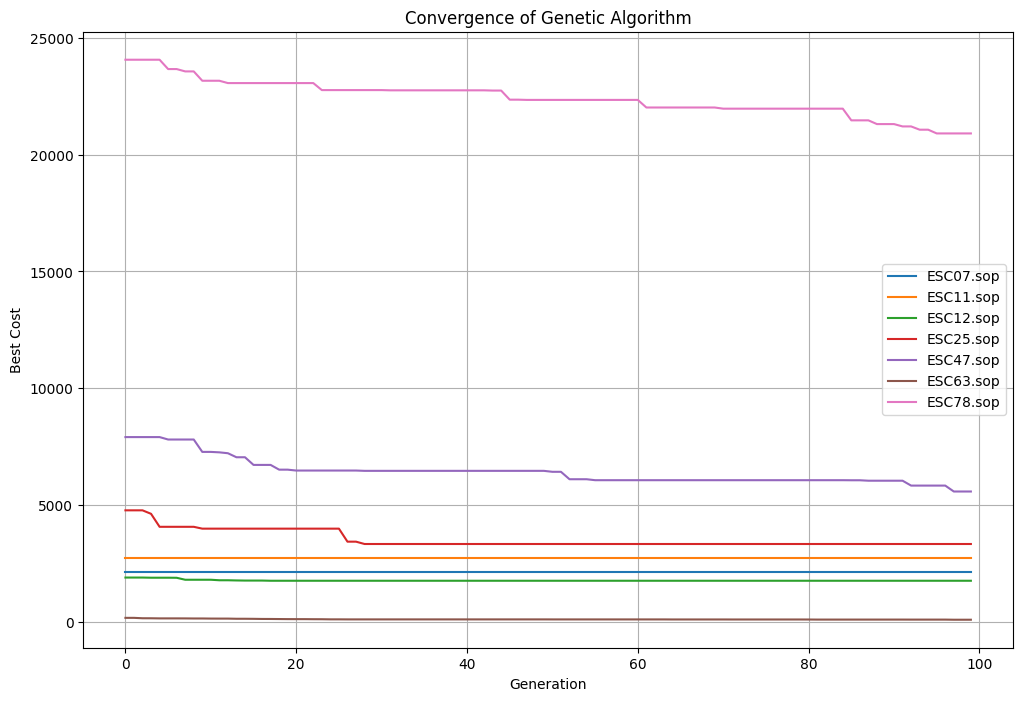

In [ ]:
def plot_convergence(results):
    plt.figure(figsize=(12, 8))
    
    for name, result in results.items():
        stats = pd.DataFrame(result['stats'])
        plt.plot(stats['generation'], stats['best_cost'], label=name)
    
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.title('Convergence of Genetic Algorithm')
    plt.legend()
    plt.grid(True)
    plt.savefig('./results/convergence_plot.png')
    plt.show()

plot_convergence(results)